# Differential expression analysis

## Install and import dependencies

In [ ]:
source("https://bioconductor.org/biocLite.R")
biocLite()

In [ ]:
biocLite(c("limma", "Glimma", "edgeR"))

In [3]:
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)

Warning message:
“package ‘limma’ was built under R version 3.4.3”Warning message:
“package ‘Glimma’ was built under R version 3.4.2”Warning message:
“package ‘edgeR’ was built under R version 3.4.3”

In [4]:
getwd()

[1] "/Users/lvulliard/OneShotProject/RecArg1"

## Example analysis
https://www.bioconductor.org/help/workflows/RNAseq123/

In [5]:
biocLite("Mus.musculus")
library(Mus.musculus)

BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.1 (2017-06-30).
Installing package(s) ‘Mus.musculus’
installing the source package ‘Mus.musculus’

Old packages: 'annotate', 'BH', 'bindr', 'biomaRt', 'blob', 'callr',
  'ChemmineR', 'd3heatmap', 'DBI', 'dbplyr', 'dendextend', 'devtools',
  'EBImage', 'ellipse', 'forcats', 'fpc', 'gdtools', 'GenomicFeatures',
  'GenomicRanges', 'git2r', 'GlobalOptions', 'haven', 'heatmaply', 'hexbin',
  'hms', 'httpuv', 'igraph', 'imageHTS', 'knitr', 'listviewer', 'lubridate',
  'MASS', 'matrixStats', 'MCPAN', 'mgcv', 'migest', 'mvtnorm', 'nlme',
  'officer', 'openssl', 'pcaPP', 'pillar', 'plogr', 'pryr', 'quantreg', 'Rcpp',
  'Rcssplot', 'RCurl', 'reprex', 'rgl', 'rlang', 'rmarkdown', 'RMySQL',
  'rpart', 'rtracklayer', 'rvg', 'selectr', 'seriation', 'shape',
  'shinydashboard', 'stringi', 'stringr', 'tibble', 'tidyr', 'tidyselect',
  'tikzDevice', 'viridis', 'viridisLite', 'withr', 'XML', 'xml2', 'yaml'
Loading

### Load input files

In [6]:
url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE63310&format=file"
utils::download.file(url, destfile="GSE63310_RAW.tar", mode="wb") 
utils::untar("GSE63310_RAW.tar", exdir = ".")
files <- c("GSM1545535_10_6_5_11.txt", "GSM1545536_9_6_5_11.txt", "GSM1545538_purep53.txt",
  "GSM1545539_JMS8-2.txt", "GSM1545540_JMS8-3.txt", "GSM1545541_JMS8-4.txt",
  "GSM1545542_JMS8-5.txt", "GSM1545544_JMS9-P7c.txt", "GSM1545545_JMS9-P8c.txt")
for(i in paste(files, ".gz", sep=""))
  R.utils::gunzip(i, overwrite=TRUE)

In [7]:
files <- c("GSM1545535_10_6_5_11.txt", "GSM1545536_9_6_5_11.txt", 
   "GSM1545538_purep53.txt", "GSM1545539_JMS8-2.txt", 
   "GSM1545540_JMS8-3.txt", "GSM1545541_JMS8-4.txt", 
   "GSM1545542_JMS8-5.txt", "GSM1545544_JMS9-P7c.txt", 
   "GSM1545545_JMS9-P8c.txt")
# Show data format
read.delim(files[1], nrow=5)

EntrezID,GeneLength,Count
497097,3634,1
100503874,3259,0
100038431,1634,0
19888,9747,0
20671,3130,1


In [8]:
# Directly construct matrix of gene count per condition
x <- readDGE(files, columns=c(1,3))
class(x)
dim(x)

[1] "DGEList"
attr(,"package")
[1] "edgeR"

[1] 27179     9

In [9]:
# Input sample annotation
samplenames <- substring(colnames(x), 12, nchar(colnames(x)))
colnames(x) <- samplenames
group <- as.factor(c("LP", "ML", "Basal", "Basal", "ML", "LP", 
                     "Basal", "ML", "LP"))
x$samples$group <- group
lane <- as.factor(rep(c("L004","L006","L008"), c(3,4,2)))
x$samples$lane <- lane
x$samples

,files,group,lib.size,norm.factors,lane
10_6_5_11,GSM1545535_10_6_5_11.txt,LP,32863052,1,L004
9_6_5_11,GSM1545536_9_6_5_11.txt,ML,35335491,1,L004
purep53,GSM1545538_purep53.txt,Basal,57160817,1,L004
JMS8-2,GSM1545539_JMS8-2.txt,Basal,51368625,1,L006
JMS8-3,GSM1545540_JMS8-3.txt,ML,75795034,1,L006
JMS8-4,GSM1545541_JMS8-4.txt,LP,60517657,1,L006
JMS8-5,GSM1545542_JMS8-5.txt,Basal,55086324,1,L006
JMS9-P7c,GSM1545544_JMS9-P7c.txt,ML,21311068,1,L008
JMS9-P8c,GSM1545545_JMS9-P8c.txt,LP,19958838,1,L008


In [10]:
# Input gene annotation
geneid <- rownames(x)
genes <- select(Mus.musculus, keys=geneid, columns=c("SYMBOL", "TXCHROM"), 
                keytype="ENTREZID")
# Choose to keep only the first chromosome position of each gene
genes <- genes[!duplicated(genes$ENTREZID),]
head(genes)

x$genes <- genes

'select()' returned 1:many mapping between keys and columns


ENTREZID,SYMBOL,TXCHROM
497097,Xkr4,chr1
100503874,Gm19938,NA
100038431,Gm10568,NA
19888,Rp1,chr1
20671,Sox17,chr1
27395,Mrpl15,chr1


### Transform and filter data on abundance
CPM (counts per million) are just normalized by abundance in sample
Allows to compare between samples but not across genes (no normalization on gene length)

In [11]:
# head(10**6 * x$counts[,3] / colSums(x$counts)[3])
xCPM = cpm(x)
xLogCPM = cpm(x, log = T)
# NB: prior count of 0.25

In [12]:
table(rowSums(x$counts==0)==9)


FALSE  TRUE 
22026  5153 

In [13]:
keep.exprs <- rowSums(xCPM>1)>=3
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x)

[1] 14165     9

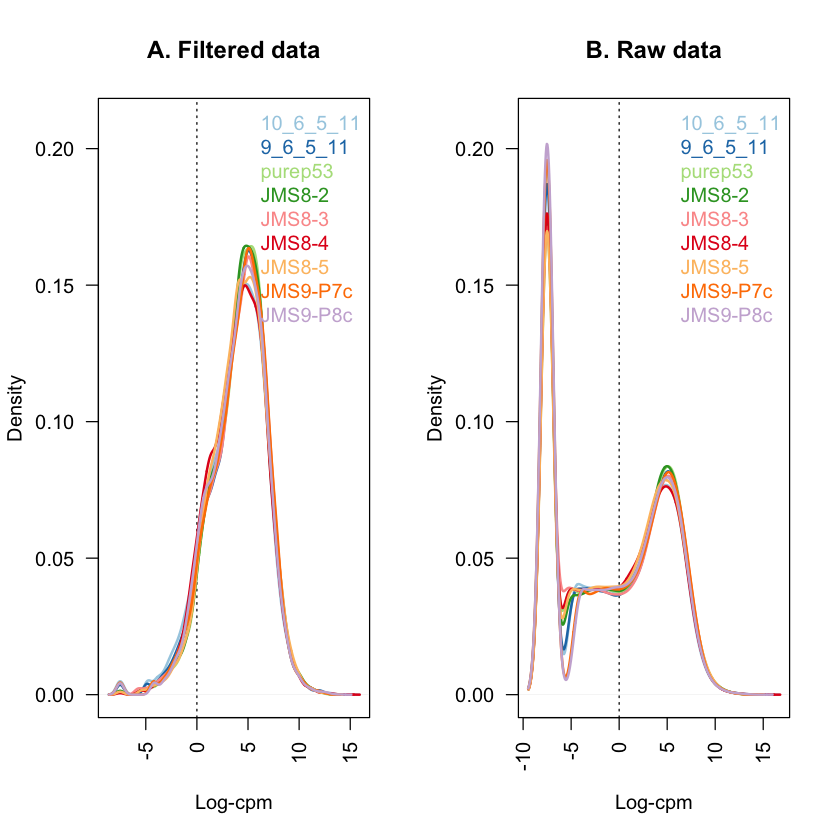

In [15]:
xLogCPMfiltered = cpm(x, log = T)

nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))



plot(density(xLogCPMfiltered[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
     main="", xlab="")
title(main="A. Filtered data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
 den <- density(xLogCPMfiltered[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

plot(density(xLogCPM[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
     main="", xlab="")
title(main="B. Raw data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
   den <- density(xLogCPM[,i])
   lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

## RecArg1 effect analysis

In [16]:
# Load data (FPKM / gene / condition)
rnaData = read.csv("RNAseq.csv", sep = ";", dec = ",")

In [17]:
# Convert to DGE object
dgeData = DGEList(counts = rnaData[,2:29], genes = rnaData[1], group = rep(1:7, 4))

In [18]:
dim(dgeData)

[1] 24775    28

In [46]:
names(dgeData)

[1] "counts"  "samples" "genes"

In [19]:
# Input sample annotation
dgeData$samples$aMEM = rep(c(TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE),4)
dgeData$samples$aMEMwoLArg = rep(c(FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE),4)
dgeData$samples$LArg = rep(c(FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE),4)
dgeData$samples$recArg = rep(c(FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE),4)
dgeData$samples$RANKL = rep(c(FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE),4)
dgeData$samples$mouse = c(rep(1,7), rep(2,7), rep(3,7), rep(4,7))
dgeData$samples

,group,lib.size,norm.factors,aMEM,aMEMwoLArg,LArg,recArg,RANKL,mouse
MCSF.only,1,635939.8,1,TRUE,FALSE,FALSE,FALSE,FALSE,1
MCSF.only...Arg.Free.Med...Dialyzed.Serum,2,630525.3,1,FALSE,TRUE,FALSE,FALSE,FALSE,1
MCSF.only...Arg.Free.Med...Dialyzed.Serum...L.Arg,3,644822.5,1,FALSE,TRUE,TRUE,FALSE,FALSE,1
Control..MCSF...RANKL,4,776441.0,1,TRUE,FALSE,FALSE,FALSE,TRUE,1
MCSF...RANKL...Arg.Free.Med...Dialyzed.Serum,5,758394.2,1,FALSE,TRUE,FALSE,FALSE,TRUE,1
MCSF...RANKL...Arg.Free.Med...Dialyzed.Serum...L.Arg,6,836530.3,1,FALSE,TRUE,TRUE,FALSE,TRUE,1
MCSF...RANKL...recArg.1000.ng.ml,7,717775.9,1,TRUE,FALSE,FALSE,TRUE,TRUE,1
MCSF.only.1,1,789636.5,1,TRUE,FALSE,FALSE,FALSE,FALSE,2
MCSF.only...Arg.Free.Med...Dialyzed.Serum.1,2,695793.6,1,FALSE,TRUE,FALSE,FALSE,FALSE,2
MCSF.only...Arg.Free.Med...Dialyzed.Serum...L.Arg.1,3,703856.0,1,FALSE,TRUE,TRUE,FALSE,FALSE,2


In [45]:
table(rowSums(dgeData$counts==0)>=25)
table(rowSums(dgeData$counts==0)==28)


FALSE  TRUE 
18482  6293 


FALSE  TRUE 
20574  4201 

4201 genes are never expressed, 6293 are not expressed in more than 3 conditions, so not even in all replicates of a single condition.

In [49]:
dgeDataExpressed <- dgeData[rowSums(dgeData$counts==0)<25,, keep.lib.sizes=FALSE]
dim(dgeDataExpressed)

[1] 18482    28

Fpkm cannot be used to compare samples so we convert values to TPM

In [50]:
fpkmToTpm <- function(fpkm)
{
    exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
}

In [67]:
dgeDataExpressed = apply(dgeDataExpressed, 2, fpkmToTpm)

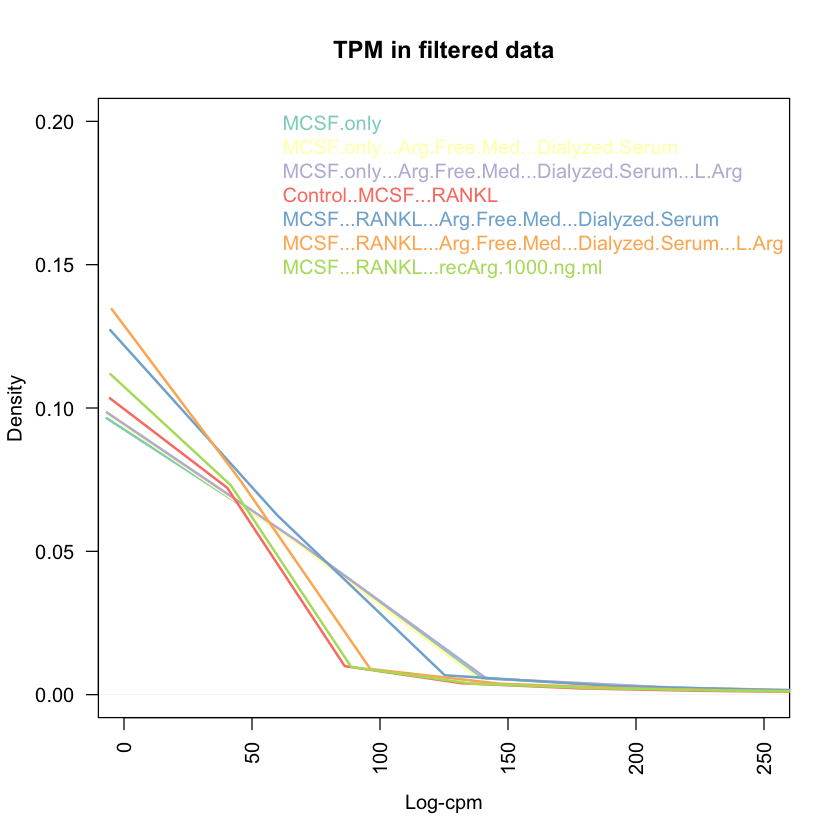

In [83]:
nsamples <- 28
col <- rep(brewer.pal(7, "Set3"))

plot(density(dgeDataExpressed[,1]), col=col[1], lwd=2, xlim = c(0,250), ylim=c(0,0.2), las=2, 
     main="", xlab="")
title(main="TPM in filtered data", xlab="Log-cpm")
for (i in 2:nsamples){
   den <- density(dgeDataExpressed[,i])
   lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(dgeData$samples)[1:7], text.col=col, bty="n")